# Exercise 1: Integration methods

Results: 1.2a
Integrated 50 result, analytical result, error 1.718281829986334 1.718281828459045 1.527288961966633e-09
Integrated 100 result, analytical result, error 1.7182818285545043 1.718281828459045 9.545919610332021e-11
Results: 1.2b
Function: sin(t)
Error between analytical solution and Fourier solution: 1.08698459946291e-16
Function: cos(t) + 3*cos(2*t) - 4*cos(3*t)
Error between analytical solution and Fourier solution: 2.60427514517978e-16
Function: sin(t) + 3*sin(3*t) + 5*sin(5*t)
Error between analytical solution and Fourier solution: 1.44377945257158e-14
Function: sin(t) + 3*sin(5*t) + 2*cos(3*t)
Error between analytical solution and Fourier solution: 5.96861121285811e-15


Text(0, 0.5, 'Amplitude (Aribtrary Unit)')

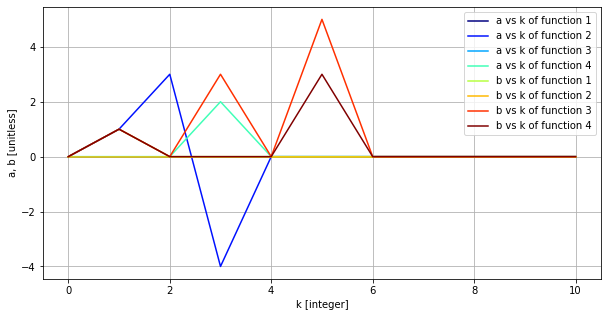

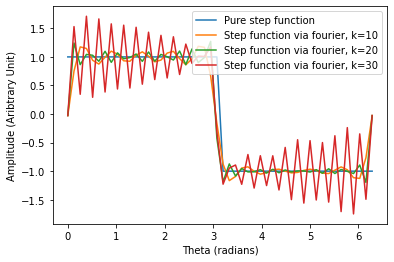

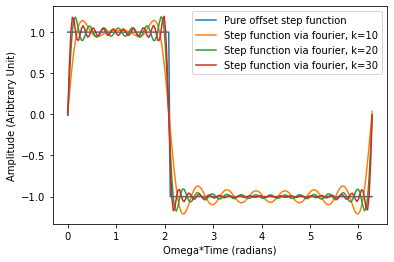

In [1]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

from functools import partial
from numpy import exp, pi
from sympy import symbols, lambdify, sin, cos, N, Piecewise
from sympy.logic.boolalg import And

## 1.2a ============================================================================

# CONSTANTS ========================================================================

a  = 0.0
b  = 1.0
n1 = 50
n2 = 100

# FUNCTIONS ========================================================================

# Copy here the simpson integration function done in class
def simpson(fun, a, b, n):
    '''implements the Simpson's Rule integration method'''
    h = (b-a)/float(n)
    
    x0 = a
    xn = b
    
    y0 = fun(x0)
    yn = fun(xn)
    
    # sum over even indexes of x and sum over odd indexes of x
    feven = 0.0
    fodd = 0.0
    
    for j in range(2,n,2):
        #print(j)
        xeven = a + j*h
        feven += fun(xeven)
        
        xodd = a + (j-1)*h
        fodd += fun(xodd)
        
    # range method above does not include the last odd term
    xodd = a + (n-1)*h
    fodd += fun(xodd)
    
    intfun = h*(y0 + 2.0*feven + 4.0*fodd + yn)/3.0
    
    return intfun

def f(x):
    ''' implements simple exponentiation function for testing'''
    return np.exp(x)

# RESULTS   ========================================================================

Int_simp_50 = simpson(f, a, b, n1)
Int_simp_100 = simpson(f, a, b, n2)
Int_analytical = exp(1.0) - 1.0

error_50 = abs(Int_analytical - Int_simp_50)
error_100 = abs(Int_analytical - Int_simp_100)
# Results, analytical solution, error
print("Results: 1.2a")
print("Integrated 50 result, analytical result, error", Int_simp_50, Int_analytical, error_50)
print("Integrated 100 result, analytical result, error", Int_simp_100, Int_analytical, error_100)

## 1.2b ============================================================================

# CONSTANTS ========================================================================
# Define parameters for the problem (omega = 1 and T is the period)
omega = 1
T = 2*pi/omega

# limits of the integration
a = 0
b = T

# number of points to calculate the integral (50 integration elements may be sufficient)
n = 50

# Number of coefficients to be calculated (set up to 10 coefficients for now)
nc = 10

k = range(0, nc, 1)

t = symbols('t', Real=True) #Everything's based on this symbol because our omega is 1

# FUNCTIONS ========================================================================
# Going off the rails

def simpsons_sympy_time(func, a, b, n):
    '''Re-implementation of the Simpsons integration function, but modified to work with sympy functions'''
    fun = lambdify(t, func) # Converts lambda function into something that the simpson code can work on
    return simpson(fun, a, b, n)

def fak(k, T, func):
    '''Calculates the a constants based on k value and period inputted'''
    C = 1/T #So I don't need to type in 1/T all the time
    if k==0:
        return C*simpsons_sympy_time(func, 0, T, n)
    func = func*cos(k*omega*t)
    return 2*C*simpsons_sympy_time(func, 0, T, n)

def fbk(k, T, func):
    '''Calculates the b constants based on k value and period inputted'''
    if k==0: # our b=0
        return 0
    C = 1/T
    func = func*sin(k*omega*t)
    return 2*C*simpsons_sympy_time(func, 0, T, n)

def reconstruct(df, omega):
    '''Uses the Fourier series to reconstruct a function and returns this function as a lambdified function for use'''
    reconstructed = 0
    for index, n in df['k'].iteritems():
        if n == 0:
            reconstructed += df.iloc[index].loc['a'] #get a0
        else:
            a = df.iloc[index].loc['a'] #a_n
            b = df.iloc[index].loc['b'] #b_n
            reconstructed += a*cos(n*omega*t)+b*sin(n*omega*t)
    return lambdify(t, reconstructed)

def df_constructor(k, func):
    '''Builds a dataframe for use using k-value and function'''
    k_range = range(0, k+1, 1)
    df = pd.DataFrame({'k': k_range}) #index would work, this is more readable
    partial_fak = partial(fak, T=T, func=func) # there might be a more elegant way of handling this
    partial_fbk = partial(fbk, T=T, func=func) # but I really love partial functions.
    df['a'] = df['k'].apply(partial_fak) #takes every k value and applies the partial function to it
    df['b'] = df['k'].apply(partial_fbk)
    return df

# I simply prefer how clean & readable this is.
f1 = sin(omega*t)
f2 = cos(omega*t) + 3*cos(2*omega*t) - 4*cos(3*omega*t)
f3 = sin(omega*t) + 3*sin(3*omega*t) + 5*sin(5*omega*t)
f4 = sin(omega*t) + 2*cos(3*omega*t) + 3*sin(5*omega*t)

# Where the Magic Happens ==========================================================
funky_list = [f1, f2, f3, f4]
df_list = []
error_list = []
for f in funky_list:
    test_func = lambdify(t, f)
    func_analytical = test_func(a) - test_func(b)
    fourier = N(simpsons_sympy_time(f, a, b, n))
    test_error = abs(fourier-func_analytical)
    error_list.append((f, test_error)) # Tuples so I can unpack this later.

    df_list.append(df_constructor(nc, f)) #we're done with the list.

#Candidate for a loop
df1, df2, df3, df4 = df_list # Unpack your bags

# RESULTS ==========================================================================
print("Results: 1.2b")
for tup in error_list:
    print('Function:', tup[0])
    print('Error between analytical solution and Fourier solution:', tup[1])

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_prop_cycle('color', [plt.cm.jet(i) for i in np.linspace(0, 1, 8)]) # https://stackoverflow.com/a/38219022
# ^ colour selection

df1.plot(x='k', y='a', label='a vs k of function 1', ax=ax)
df2.plot(x='k', y='a', label='a vs k of function 2', ax=ax)
df3.plot(x='k', y='a', label='a vs k of function 3', ax=ax)
df4.plot(x='k', y='a', label='a vs k of function 4', ax=ax)

#ax.set_size(10, 10)

#ax2 = ax.twinx()
#ax2.set_prop_cycle('color', [plt.cm.jet(i) for i in np.linspace(0.5, 1, 4)]) # https://stackoverflow.com/a/38219022
# ^ if we want 2 axes
df1.plot(x='k', y='b', label='b vs k of function 1', ax=ax)
df2.plot(x='k', y='b', label='b vs k of function 2', ax=ax)
df3.plot(x='k', y='b', label='b vs k of function 3', ax=ax)
df4.plot(x='k', y='b', label='b vs k of function 4', ax=ax)
ax.grid()
ax.set_xlabel('k [integer]')
ax.set_ylabel('a, b [unitless]')
#ax2.set_ylabel('b [unitless]')
#ax.legend(loc=0)
#ax2.legend(loc=4)

## 1.2C============================================================

theta = omega*t

c_func = Piecewise( ( 1, And(0 <= theta, theta <=   pi)), #Sympy Piecewise function
                    (-1, And(pi < theta, theta <= 2*pi)) #Works just like the math thing
                    ) #And function because Sympy needs special boolean logic
c_piece = lambdify(theta, c_func) #For pure calculation
thetas = np.linspace(0, 2*pi, n) #Our X's

df_12c   = df_constructor(10, c_func) #K's 10-30
df_12c20 = df_constructor(20, c_func)
df_12c30 = df_constructor(30, c_func)
toplot10c = reconstruct(df_12c, omega)(thetas) #Resulting functions (lambdified)
toplot20c = reconstruct(df_12c20, omega)(thetas)
toplot30c = reconstruct(df_12c30, omega)(thetas)

fig2, ax2 = plt.subplots() #New plot
ax2.plot(thetas, c_piece(thetas), label='Pure step function')
ax2.plot(thetas, toplot10c, label='Step function via fourier, k=10')
ax2.plot(thetas, toplot20c, label='Step function via fourier, k=20')
ax2.plot(thetas, toplot30c, label='Step function via fourier, k=30')
ax2.legend(loc='upper right') #Puts it in the centre without this, which is bad
ax2.set_xlabel('Theta (radians)')
ax2.set_ylabel('Amplitude (Aribtrary Unit)')
## 1.2D=============================================================
n = 200
a = 3 #Change this for modifying the offset
wtau = (2*pi)/a 
wt = omega*t
#Pretty much everything is the same as above, so not commenting
d_func= Piecewise( ( 1, And(0 <= wt, wt <= wtau)),
                    (-1, And(wtau < wt, wt <= 2*pi)) 
                    )

d_piece = lambdify(t, d_func)

wts = np.linspace(0, 2*pi, n)
y_wts = d_piece(wts)
df_12d   = df_constructor(10, d_func)
df_12d20 = df_constructor(20, d_func)
df_12d30 = df_constructor(30, d_func)
#df_12d100 = df_constructor(100, d_func)
toplot10d = reconstruct(df_12d, omega)(wts)
toplot20d = reconstruct(df_12d20, omega)(wts)
toplot30d = reconstruct(df_12d30, omega)(wts)

fig3, ax3 = plt.subplots()

ax3.plot(wts, y_wts, label='Pure offset step function')
ax3.plot(wts, toplot10d, label='Step function via fourier, k=10')
ax3.plot(wts, toplot20d, label='Step function via fourier, k=20')
ax3.plot(wts, toplot30d, label='Step function via fourier, k=30')
ax3.legend()
ax3.set_xlabel('Omega*Time (radians)')
ax3.set_ylabel('Amplitude (Aribtrary Unit)')